In [14]:
import numpy as np
from numpy import cos as c
from numpy import sin as s

from scipy import integrate
from scipy.interpolate import UnivariateSpline
from scipy.optimize import curve_fit
from scipy.optimize import broyden1
from scipy.stats import gamma
from scipy.stats import lognorm
from scipy.stats import maxwell
from scipy.fftpack import fft, ifft
# from common_dists import PERT

import matplotlib.pyplot as plt
from matplotlib import gridspec
from matplotlib.offsetbox import AnchoredText
from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib.colors import LogNorm
from matplotlib.ticker import LogFormatterMathtext
plt.style.use("paper.mplstyle")


In [3]:
mc_arr   = np.load("/data/user/jlazar/solar_WIMP/data/mcRecarray.npy")
nuZens   = mc_arr["nuZen"]
nuAzs    = mc_arr["nuAz"]
recoZens = mc_arr["recoZen"]
recoAzs  = mc_arr["recoAz"]
log10nuE = np.log10(mc_arr["nuE"])

In [4]:
log10e_edges = np.linspace(2,6,41)
nue = np.power(10, log10e_edges)
nue_cents = (nue[:-1]+nue[1:])/2.

delta_psi_edges = np.logspace(-4,2,101)
delta_psi_centers = (delta_psi_edges[1:]+delta_psi_edges[:-1])/2.
delta_psi_widths  = delta_psi_edges[1:]-delta_psi_edges[:-1]

In [5]:
def opening_angle(zen1, az1, zen2, az2):
    return np.arccos(np.sin(zen1)*np.sin(zen2)*np.cos(az1-az2)+np.cos(zen1)*np.cos(zen2))

In [6]:
def rotate_coords(nu_az, nu_zen, gen_az, gen_zen):
    reco_x   =  c(nu_az)*c(nu_zen)*c(gen_az)*s(gen_zen) - s(nu_az)*s(gen_az)*s(gen_zen) + c(nu_az)*s(nu_zen)*c(gen_zen)
    reco_y   =  s(nu_az)*c(nu_zen)*c(gen_az)*s(gen_zen) + c(nu_az)*s(gen_az)*s(gen_zen) + s(nu_az)*s(nu_zen)*c(gen_zen)
    reco_z   = -s(nu_zen)*c(gen_az)*s(gen_zen) + c(nu_zen)*c(gen_zen)
    reco_az  = np.arctan(reco_y / reco_x)+np.pi
    reco_zen = np.arccos(reco_z)
    return reco_az, reco_zen

In [7]:
def get_zeros_outta_there(arr):
    arr = np.asarray(arr)
    max_i = np.argmax(arr)
    zeros_i = np.argwhere(arr==0)
    arr1 = np.delete(zeros_i, np.argwhere(zeros_i>max_i))
    arr2 = np.delete(zeros_i, np.argwhere(zeros_i<max_i))
    return max(arr1)+1, min(arr2)

In [8]:
def maxwell(x, a):
    return 4. / (np.sqrt(np.pi)*a**3)*x**2*np.exp(-x**2)

In [9]:
opening_angles = np.degrees(opening_angle(nuZens, nuAzs, recoZens, recoAzs))

In [10]:
h = np.histogram2d(log10nuE, opening_angles, bins=[log10e_edges, delta_psi_edges])

med_error = []
norms     = []
for j, arr in enumerate(h[0][3:]):
    
    i0, i1 = get_zeros_outta_there(arr)
    arr    = np.concatenate([np.ones(i0), arr[i0:i1], np.ones(len(arr)-i1)])
    delta_psi_centers_good = delta_psi_centers[i0:i1]
    
    dn_dtheta = arr / np.log(10) / delta_psi_centers
    
    f   = UnivariateSpline(np.log10(delta_psi_centers), np.log10(dn_dtheta), k=5, s=1e-3)
#     f   = UnivariateSpline(np.log10(delta_psi_centers), np.log10(dn_dtheta), k=5, s=1e-5)
    
    
    def dn_dtheta_interp(x):
        logx = f(np.log10(x))
        return np.power(10, logx)
    
    def cdf(y, norm):

        i = integrate.quad(lambda x: np.exp(x)*dn_dtheta_interp(np.exp(x)), np.log(delta_psi_centers_good)[0], np.log(y))
        return i[0] / norm

    i = integrate.quad(lambda x: np.exp(x)*dn_dtheta_interp(np.exp(x)), np.log(delta_psi_centers_good)[0], np.log(delta_psi_centers_good)[-1])


    print(i[1] / i[0])
    norm = i[0]
    norms.append(norm)
    
    xx = np.logspace(np.log10(delta_psi_centers_good[0]), np.log10(delta_psi_centers_good[-1]), 1001)
    yy = [cdf(x, norm) for x in xx]
    spline = dn_dtheta_interp(xx)
    
    p      = (spline[1:]+spline[:-1])/2*(xx[1:]-xx[:-1])/norm / sum((spline[1:]+spline[:-1])/2*(xx[1:]-xx[:-1])/norm)
    median = np.median(np.random.choice((xx[1:]+xx[:-1])/2, 10000, p=p))
    med_error.append(median)
    
#     plt.step(delta_psi_centers, dn_dtheta / norm)
#     plt.step(xx,spline / norm)
#     plt.step(xx,yy)
# #     plt.semilogx()

#     plt.axvline(median)
    
#     plt.title(nue_cents[j+3])
#     plt.xlim(1e-3,5)
#     plt.ylim(0,2)
#     plt.grid()
#     plt.show()

1.36921648698e-08
9.23431056724e-09
9.97912517493e-09
7.44837136918e-09
1.42496558316e-08
5.78012258804e-09
1.09405871876e-08
1.42616462917e-08
1.03542358502e-08
1.00985135324e-08
6.19773535063e-09
1.37873178924e-08
1.06886982947e-08
1.33393037232e-08
9.88791164006e-09
1.26743926462e-08
1.14137552138e-08
1.39352544981e-08
1.0492796656e-08
1.39580803735e-08
1.31664487077e-08
1.15623644761e-08
1.3731674811e-08
1.22942104484e-08
1.38681574055e-08
1.41079158741e-08
1.39072082905e-08
1.28437255861e-08
1.35325265684e-08
1.26284798541e-08
1.24875462239e-08
1.27633345606e-08
1.2709985788e-08
1.26029606064e-08
1.39786702963e-08
1.24522589293e-08
1.34200773886e-08


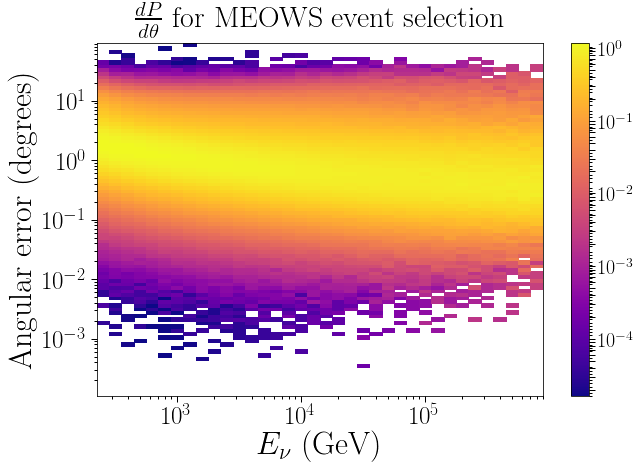

In [16]:
X,Y=np.meshgrid(nue_cents[3:],delta_psi_centers)

fig = plt.figure(figsize=(10,6.5))

hist = (h[0][3:].T / [norms for i in range(100)])
im = plt.pcolor(X, Y, hist, norm=LogNorm())

plt.xscale('log')
plt.yscale('log')

plt.xlabel(r"$E_{\nu}$ (GeV)")
plt.ylabel("Angular error (degrees)")
plt.title(r"$\frac{dP}{d\theta}$ for MEOWS event selection", fontsize=30)


cbar = plt.colorbar(im, orientation='vertical',format=LogFormatterMathtext())
cbar.ax.tick_params(labelsize=20) 

plt.tick_params(labelsize=25)


plt.savefig("plots/MEOWS_angular_erros_hm.png", dpi=400, bbox_inches="tight")
plt.show()
# print(np.divide(h[0][3:], norms, axis=0) )

In [24]:
## # e_cents = (e_bins[:-1]+e_bins[1:])/2
# med_error = []
# norms     = []
# for j, arr in enumerate(h[0][3:]):
    
#     i0, i1 = get_zeros_outta_there(arr)
#     arr    = np.concatenate([np.ones(i0), arr[i0:i1], np.ones(len(arr)-i1)])
#     delta_psi_centers_good = delta_psi_centers[i0:i1]
    
#     dn_dtheta = arr / np.log(10) / delta_psi_centers
    
#     f   = UnivariateSpline(np.log10(delta_psi_centers), np.log10(dn_dtheta), k=5, s=1e-4)
# #     f   = UnivariateSpline(np.log10(delta_psi_centers), np.log10(dn_dtheta), k=5, s=1e-5)
    
    
#     def dn_dtheta_interp(x):
#         logx = f(np.log10(x))
#         return np.power(10, logx)
    
#     def cdf(y, norm):

#         i = integrate.quad(lambda x: np.exp(x)*dn_dtheta_interp(np.exp(x)), np.log(delta_psi_centers_good)[0], np.log(y))
#         return i[0] / norm

#     i = integrate.quad(lambda x: np.exp(x)*dn_dtheta_interp(np.exp(x)), np.log(delta_psi_centers_good)[0], np.log(delta_psi_centers_good)[-1])


#     print(i[1] / i[0])
#     norm = i[0]
#     norms.append(norm)
    
#     xx = np.logspace(np.log10(delta_psi_centers_good[0]), np.log10(delta_psi_centers_good[-1]), 1001)
#     yy = [cdf(x, norm) for x in xx]
#     spline = dn_dtheta_interp(xx)
    
#     p      = (spline[1:]+spline[:-1])/2*(xx[1:]-xx[:-1])/norm / sum((spline[1:]+spline[:-1])/2*(xx[1:]-xx[:-1])/norm)
#     median = np.median(np.random.choice((xx[1:]+xx[:-1])/2, 10000, p=p))
#     med_error.append(median)
    
#     plt.step(delta_psi_centers, dn_dtheta / norm)
#     plt.step(xx,spline / norm)
#     plt.step(xx,yy)
# #     plt.semilogx()

#     plt.axvline(median)
    
#     plt.title(nue_cents[j+3])
#     plt.xlim(1e-3,5)
#     plt.ylim(0,2)
#     plt.grid()
#     plt.show()

In [25]:
# p = (spline[1:]+spline[:-1])/2*(xx[1:]-xx[:-1])/norm / sum((spline[1:]+spline[:-1])/2*(xx[1:]-xx[:-1])/norm)
# np.median(np.random.choice((xx[1:]+xx[:-1])/2, 10000, p=p))

In [26]:
# sum((spline[1:]+spline[:-1])/2*(xx[1:]-xx[:-1])/norm)

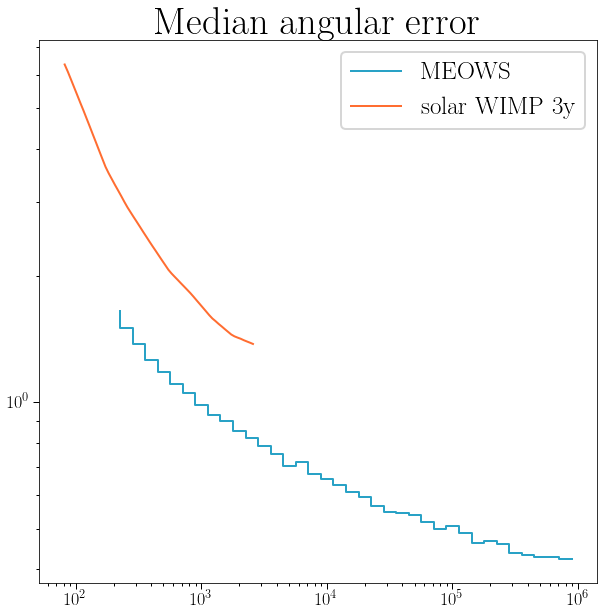

In [27]:
_ = np.genfromtxt("/data/user/jlazar/solar_WIMP/data//3y_solar_WIMP_ang_res.csv", delimiter=",").T
old_e   = _[0]
old_res = _[1]

plt.step(nue_cents[3:], med_error, label="MEOWS")
plt.plot(old_e, old_res, label="solar WIMP 3y")
plt.loglog()

plt.title("Median angular error")
plt.legend()

plt.show()


In [28]:
MEOWS_spline = UnivariateSpline(np.log10(nue_cents[3:]), np.log10(med_error), k=3, )
solar_WIMP_3y_spline = UnivariateSpline(np.log10(old_e), np.log10(old_res), k=3, )

def MEOWS_error(nu_e):
    log10err = MEOWS_spline(np.log10(nu_e))
    return 10**log10err

def sw_3y_error(nu_e):
    log10err = solar_WIMP_3y_spline(np.log10(nu_e))
    return 10**log10err

def ratio(nu_e):
    return np.divide(sw_3y_error(nu_e), MEOWS_error(nu_e))

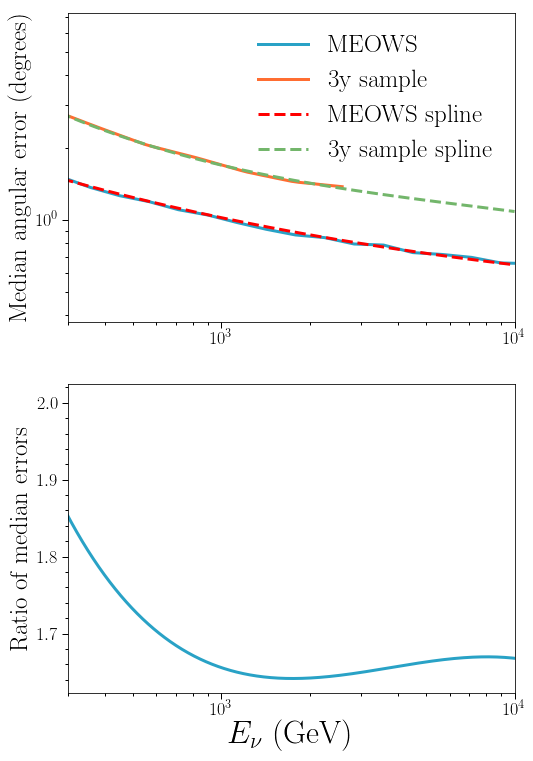

In [55]:
lw=3
ls="--"

fig = plt.figure(figsize=(8,12.5))
gs = gridspec.GridSpec (2, 1,height_ratios=[1,1])
(ax1, ax2) = (fig.add_subplot(gs[0]), fig.add_subplot(gs[1]))

#### Top plot ####

ax1.plot(nue_cents[3:], med_error, label="MEOWS", lw=lw)
ax1.plot(old_e, old_res, label="3y sample", lw=lw)
ax1.plot(np.logspace(np.log10(200),4,1000), MEOWS_error(np.logspace(np.log10(200),4,1000)), 
         label="MEOWS spline", lw=lw, linestyle=ls, color="r")
ax1.plot(np.logspace(np.log10(200),4,1000), sw_3y_error(np.logspace(np.log10(200),4,1000)),
         label="3y sample spline", lw=lw, linestyle=ls)

# ax1.set_xlabel(r"$E_{\nu}$ (GeV)")
ax1.set_ylabel(r"Median angular error (degrees)", fontsize=25)

ax1.legend(frameon=False)

ax1.loglog()
ax1.set_xlim(300,10000)

#### Bottom plot ####

ax2.plot(np.logspace(np.log10(200),4,1000), ratio(np.logspace(np.log10(200),4,1000)),
         lw=lw)

ax2.set_ylabel("Ratio of median errors", fontsize=25)
ax2.set_xlabel(r"$E_{\nu}$ (GeV)")
# ax2.set_title("Ratio of MEOWS median angular error to\n 3y solar WIMP median angular error")

ax2.semilogx()
ax2.set_xlim(300,10000)

plt.savefig("plots/median_error_comparison.png", dpi=400, bbox_inches="tight")

plt.show()

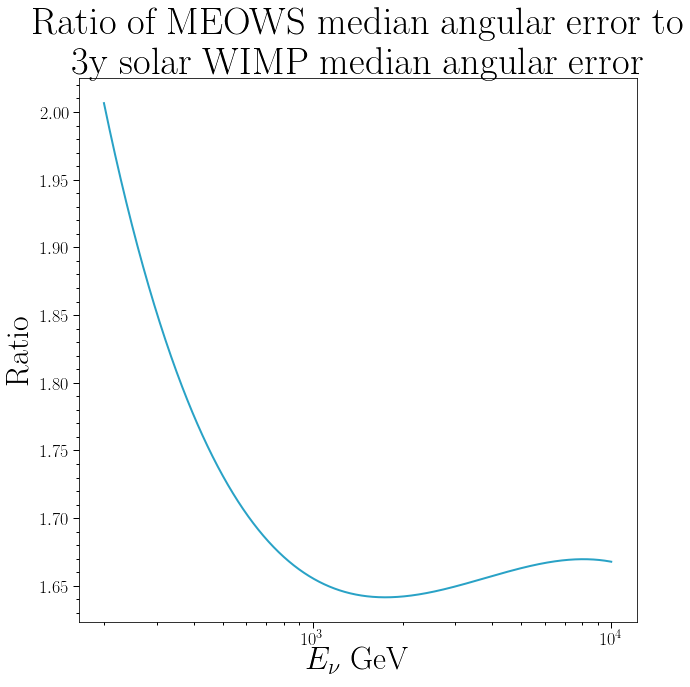

In [40]:
plt.plot(np.logspace(np.log10(200),4,1000), ratio(np.logspace(np.log10(200),4,1000)),)

plt.ylabel("Ratio")
plt.xlabel(r"$E_{\nu}$ GeV")
plt.title("Ratio of MEOWS median angular error to\n 3y solar WIMP median angular error")

plt.semilogx()

plt.show()

In [12]:
# # arr = np.full(len(log10nuE), np.nan)
# np.random.seed(400)

# gen_op_ang1 = np.multiply(ratio(np.power(10,log10nuE)), 
#                             np.radians(opening_angles), 
#                             where=~(log10nuE>4), 
# #                             out=np.full(len(log10nuE), np.nan)
#                           )
# gen_az1 = np.random.rand(len(gen_op_ang1))*2*np.pi
# print(gen_op_ang1)
# r_az1, r_zen1 = rotate_coords(nuAzs, nuZens, gen_az1, gen_op_ang1)
# print(opening_angle(r_zen1, r_az1, nuZens, nuAzs))
# arr1 = np.recarray(len(r_az1), 
#                   dtype=[("rescaled_reco_az", float),
#                          ("rescaled_reco_zen", float)]
#                  )
# arr1["rescaled_reco_az"][:] = r_az1
# arr1["rescaled_reco_zen"][:] = r_zen1

# np.save("/Users/jlazar/Documents/IceCube/solar_WIMP/data/rescaled_reco_angles.npy", arr)

In [13]:
# # arr = np.full(len(log10nuE), np.nan)
# np.random.seed(400)

# gen_op_ang2 = np.multiply(ratio(np.power(10,log10nuE)), 
#                             np.radians(opening_angles), 
#                             where=~(log10nuE>4), 
#                             out=np.random.rand(len(log10nuE))*np.pi
#                         )
# gen_az2 = np.random.rand(len(gen_op_ang2))*2*np.pi
# print(gen_op_ang2)
# r_az2, r_zen2 = rotate_coords(nuAzs, nuZens, gen_az2, gen_op_ang2)
# print(opening_angle(r_zen2, r_az2, nuZens, nuAzs))
# arr2 = np.recarray(len(r_az), 
#                   dtype=[("rescaled_reco_az", float),
#                          ("rescaled_reco_zen", float)]
#                  )
# arr2["rescaled_reco_az"][:] = r_az2
# arr2["rescaled_reco_zen"][:] = r_zen2

# np.save("/Users/jlazar/Documents/IceCube/solar_WIMP/data/rescaled_reco_angles_rand.npy", arr)

In [14]:
# np.load("/Users/jlazar/Documents/IceCube/solar_WIMP/data/mc_dn_dz/ch5_m4000_mc_dn_dz.npy")[np.where(gen_op_ang1==gen_op_ang2)[0]]

In [28]:
arr1 = np.load("/data/user/jlazar/solar_WIMP/data/e_d_theta_hist/partial_hists/ch5_m1000_nu_0_energy_delta_theta_hist_rescale_0.npy")
arr2 = np.load("/data/user/jlazar/solar_WIMP/data/e_d_theta_hist/partial_hists/ch5_m1000_nu_0_energy_delta_theta_hist_rescale_1.npy")
r = arr1 / arr2

/cvmfs/icecube.opensciencegrid.org/py2-v3/RHEL_7_x86_64/lib/python2.7/site-packages/ipykernel_launcher.py:3: RuntimeWarning: invalid value encountered in divide
  This is separate from the ipykernel package so we can avoid doing imports until


In [122]:
def lognorm(x, sigma, mu):
    return (1./x)*(1/(sigma*np.sqrt(2*np.pi)))*np.exp(-np.power(np.log(x)-mu, 2)/(2*sigma**2))
def exp(x, lamb):
    return np.exp(-lamb*x)
def lognorm_cdf(x, sigma, mu):
    return integrate.quad(lognorm, 0., float(x), args=(sigma, mu))
def exp_cdf(x, lamb):
    return 1-np.exp(-lamb*x)

In [123]:
lognorm_cdf(100., 0.25, 0.)

(1.0, 2.0179993522991163e-12)

In [124]:
def min_x(sigma, mu, lamb, inc=0.9991):
    func  = lambda x: lognorm_cdf(x, sigma, mu)[0] - inc
    x_in = 3*mu+1
    x_ln = broyden1(func, x_in)
    func  = lambda x: exp_cdf(x, lamb) - inc
    x_exp = broyden1(func, 2)
    return max([x_ln, x_exp])

In [159]:
sigma = 0.25
mu = 0
lamb = 0.5
def ln_conv_exp(sigma, mu, lamb):
    mx = min_x(sigma, mu, lamb)
    xx = np.linspace(0.001, mx, 100)
    fft_ln  = fft(lognorm(xx, sigma, mu))
    fft_exp = fft(exp(xx, lamb))
    
    conv = np.real(ifft(fft_ln * fft_exp))
    assert np.max(np.imag(conv)) < 1e-10
    
    return xx, np.real(conv)

def lalala(x, sigma, mu, lamb, scale):
    f = UnivariateSpline(*ln_conv_exp(sigma, mu, lamb), k=5, s=1e-3)
    return scale*f(x)


popt_conv, popt_gamma  = curve_fit(lalala, delta_psi_centers,dp_dtheta, p0=[0.75931464, 0.16498149, 0.5, 1])
plt.plot()

/cvmfs/icecube.opensciencegrid.org/py2-v3/RHEL_7_x86_64/lib/python2.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in log
  


ValueError: array must not contain infs or NaNs

In [134]:
sigma = 0.25
mu = 0
lamb = 2
mx = min_x(sigma, mu, lamb)
print(exp_cdf(mx, lamb))
print(lognorm_cdf(mx, sigma, mu)[0])

0.9990997060304565
0.999999739419


/cvmfs/icecube.opensciencegrid.org/py2-v3/RHEL_7_x86_64/lib/python2.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: divide by zero encountered in divide
  
/cvmfs/icecube.opensciencegrid.org/py2-v3/RHEL_7_x86_64/lib/python2.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: divide by zero encountered in log
  
/cvmfs/icecube.opensciencegrid.org/py2-v3/RHEL_7_x86_64/lib/python2.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in multiply
  


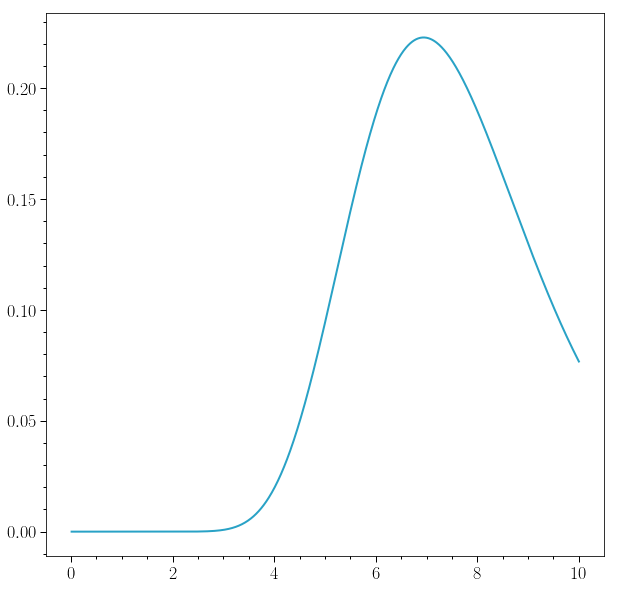

In [68]:
xx = np.linspace(0,10,1000)
plt.plot(xx, lognorm(xx, sigma, mu))

In [156]:
arr = h[0][4]

i0, i1 = get_zeros_outta_there(arr)
arr    = np.concatenate([np.ones(i0), arr[i0:i1], np.ones(len(arr)-i1)])
delta_psi_centers_good = delta_psi_centers[i0:i1]

dn_dtheta = arr / np.log(10) / delta_psi_centers

f   = UnivariateSpline(np.log10(delta_psi_centers), np.log10(dn_dtheta), k=5, s=1e-5)


# def dn_dtheta_interp(x):
#     logx = f(np.log10(x))
#     return np.power(10, logx)

# def cdf(y, norm):

#     i = integrate.quad(lambda x: np.exp(x)*dn_dtheta_interp(np.exp(x)), np.log(delta_psi_centers_good)[0], np.log(y))
#     return i[0] / norm

# i = integrate.quad(lambda x: np.exp(x)*dn_dtheta_interp(np.exp(x)), np.log(delta_psi_centers_good)[0], np.log(delta_psi_centers_good)[-1])


# print(i[1] / i[0])
norm = norms[0]
# norms.append(norm)

xx = np.logspace(np.log10(delta_psi_centers_good[0]), np.log10(delta_psi_centers_good[-1]), 1001)
# yy = [cdf(x, norm) for x in xx]
spline = dn_dtheta_interp(xx)

# Find median of distribution
p      = (spline[1:]+spline[:-1])/2*(xx[1:]-xx[:-1])/norm / sum((spline[1:]+spline[:-1])/2*(xx[1:]-xx[:-1])/norm)
median = np.median(np.random.choice((xx[1:]+xx[:-1])/2, 10000, p=p))

dp_dtheta = dn_dtheta / norm

# popt_gamma, pcov_gamma = curve_fit(gamma.pdf, delta_psi_centers,dp_dtheta, p0=[1])
popt_logn, pcov_logn   = curve_fit(lognorm, delta_psi_centers,dp_dtheta, p0=[1,1])
print(popt_logn)
popt_conv, pcov_conv  = curve_fit(lalala, delta_psi_centers,dp_dtheta, p0=[popt_logn[0], popt_logn[1], 0.5, 1])
# popt_max, pcov_max   = curve_fit(maxwell, delta_psi_centers,dp_dtheta, p0=[1])
    
plt.step(delta_psi_centers, dp_dtheta, label="data")
# plt.step(xx,spline / norm)
plt.plot(delta_psi_centers,lalala(delta_psi_centers,*popt_conv), label='conv. fit')
plt.plot(delta_psi_centers,gamma.pdf(delta_psi_centers,*popt_gamma), label='gamma fit')
# plt.plot(delta_psi_centers,lognorm.pdf(delta_psi_centers,*popt_logn), label='lognorm fit')
# plt.plot(delta_psi_centers,maxwell(delta_psi_centers,*popt_max), label='maxwell fit')
# plt.step(xx,yy)
# plt.semilogx()

plt.legend()
# plt.axvline(median)

plt.title(nue_cents[4])
plt.xlim(1e-3,5)
plt.ylim(0,2)
plt.grid()
plt.show()

[0.75931464 0.16498149]


/cvmfs/icecube.opensciencegrid.org/py2-v3/RHEL_7_x86_64/lib/python2.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in log
  


ValueError: array must not contain infs or NaNs

[]

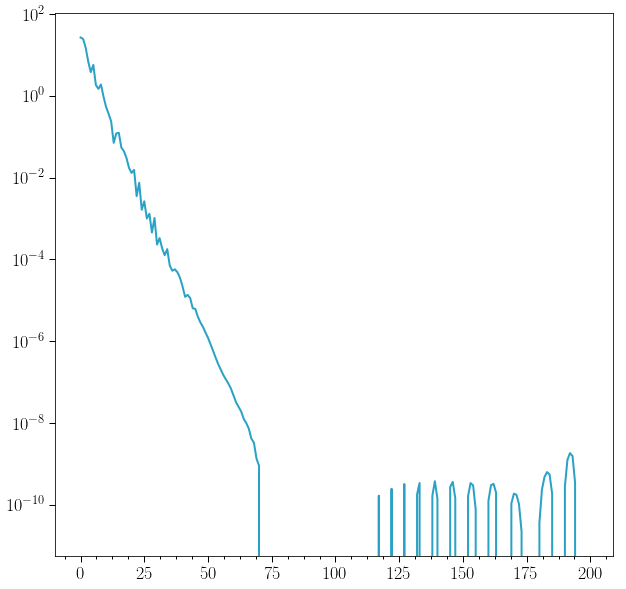

In [19]:
plt.plot(np.load("data/qr_dn_dz/ch11_m10000_dn_dz.npy")[0][0])
plt.semilogy()

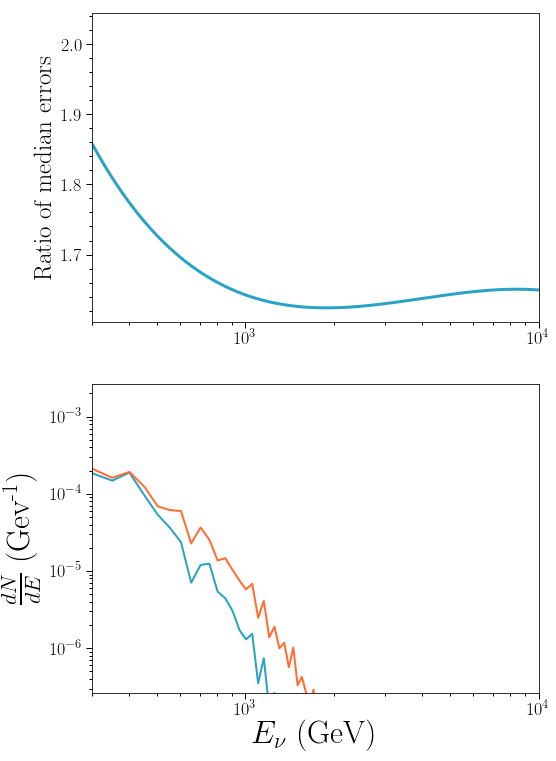

In [35]:
lw=3
ls="--"

nu_flux = np.load("data/qr_dn_dz/ch11_m10000_dn_dz.npy")[0][0]/10000
nu_bar_flux = np.load("data/qr_dn_dz/ch11_m10000_dn_dz.npy")[1][0]/10000
ee = np.linspace(0,10000, len(nu_flux))

fig = plt.figure(figsize=(8,12.5))
gs = gridspec.GridSpec (2, 1,height_ratios=[1,1])
(ax2, ax1) = (fig.add_subplot(gs[0]), fig.add_subplot(gs[1]))

#### Top plot ####

ax2.plot(np.logspace(np.log10(200),4,1000), ratio(np.logspace(np.log10(200),4,1000)),
         lw=lw)

ax2.set_ylabel("Ratio of median errors", fontsize=25)
# ax2.set_xlabel(r"$E_{\nu}$ (GeV)")
# ax2.set_title("Ratio of MEOWS median angular error to\n 3y solar WIMP median angular error")

ax2.semilogx()
ax2.set_xlim(300,10000)

#### Bottom plot ####

ax1.set_xlabel(r"$E_{\nu}$ (GeV)")

ax1.plot(ee, nu_flux, label=r"$\nu_{\mu}$")
ax1.plot(ee, nu_bar_flux, label=r"bar{\nu}_{\mu}$")

ax1.loglog()
ax1.set_xlim(300,10000)
ax1.set_xlabel(r"$E_{\nu}$ (GeV)")

ax1.set_ylabel(r"$\frac{dN}{dE}$ (Gev\textsuperscript{-1})")
ax1.set_ylim(np.max(nu_flux)/10000, np.max(nu_flux))


plt.savefig("plots/median_error_and_dN_dE.png", dpi=400, bbox_inches="tight")

plt.show()